In [13]:
from tensorflow import keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from classification_models.tfkeras import Classifiers

import numpy as np

import matplotlib.pyplot as plt


In [59]:
train_dir = "data/classify/train"
val_dir = "data/classify/val"
img_size = (448, 448)
input_channels = 3
n_classes = 2
batch_size = 8

In [15]:
def plt_display(image, title):
    fig = plt.figure()
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    a.set_title(title)

Found 998 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


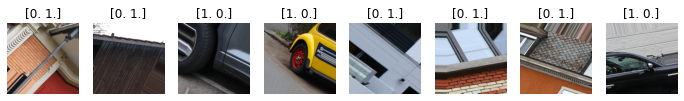

In [58]:
ResNet18, _ = Classifiers.get('resnet18')

def preprocess_image(image):
    return image.astype(np.float32) / 255

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)
    
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=img_size, 
    batch_size=batch_size, 
    class_mode='categorical'
)

x_batch, y_batch = next(train_generator)

fig = plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch, y_batch)):
    s = plt.subplot(4, 8, k+1)
    plt.imshow(img)
    s.set_title(lbl)
    plt.axis('off')

In [62]:
import tensorflow.keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [63]:
base_model = ResNet18(input_shape=(448,448,3), weights='imagenet', include_top=False)
x = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation='softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# train
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', f1_metric])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 448, 448, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_18 (ZeroPadding2 (None, 454, 454, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 224, 224, 64) 9408        zero_padding2d_18[0][0]          
____________________________________________________________________________________________

In [64]:
epochs = 1

callbacks = [
    keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
]


model.fit(
    train_generator, 
    epochs=epochs, 
    validation_data=validation_generator, 
    callbacks=callbacks
)

 25/125 [=====>........................] - ETA: 8:53 - loss: 0.9044 - accuracy: 0.7552 - f1_metric: 0.7552

KeyboardInterrupt: 

In [78]:
from isp.models.unet_1loss import get_model

isp_model = get_model(input_shape=(224, 224, 4))
model.trainable = False
#isp_model.load_weights('unet_1loss.h5')

modelC=Model(
    inputs=isp_model.inputs,
    outputs=model(isp_model(isp_model.inputs))
)
modelC.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 4)]     0         
_________________________________________________________________
model_9 (Functional)         (None, 448, 448, 3)       7767107   
_________________________________________________________________
model_3 (Functional)         (None, 2)                 11187915  
Total params: 18,955,022
Trainable params: 7,767,107
Non-trainable params: 11,187,915
_________________________________________________________________
